In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

In [2]:
'''helper function to display images'''
def display_images(images,titles,row,col):
    fig = plt.figure(figsize = (20,20))
    for i in range(len(images)):
        fig.add_subplot(row,col,i + 1)
        #RGB
        if np.ndim(images[i]) == 3:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i],cmap = 'gray')
        plt.title(titles[i])
        plt.axis("off")
    

(573, 943, 4)
(573, 943, 4)


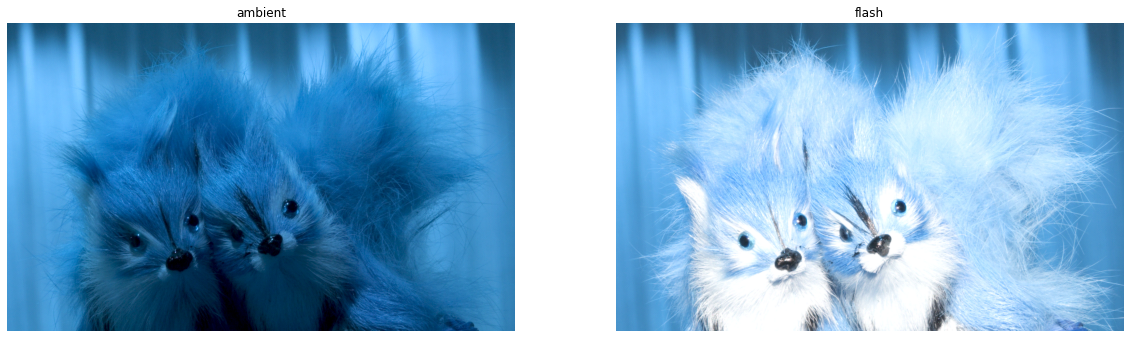

In [3]:
''' load the a pair of flash and no flash image '''
flash = cv2.imread("./../data/flash.png",cv2.IMREAD_UNCHANGED)
ambient = cv2.imread("./../data/noflash.png",cv2.IMREAD_UNCHANGED)
display_images([ambient,flash],['ambient','flash'],1,2)

print(flash.shape)
print(ambient.shape)

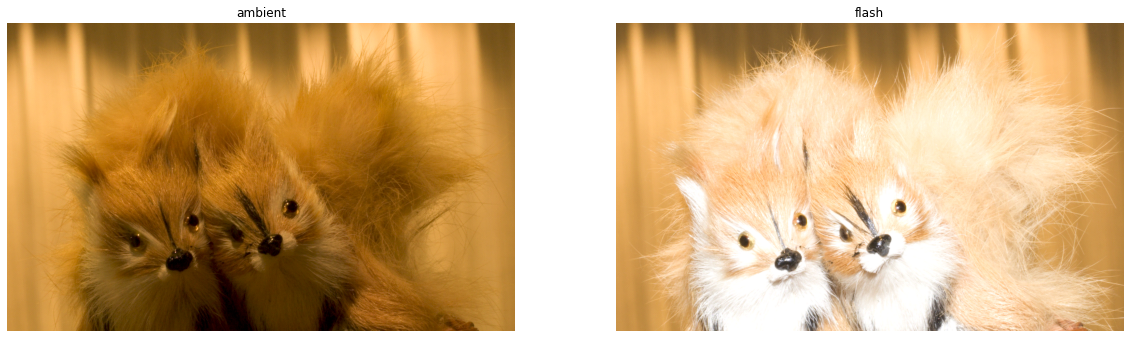

In [4]:
''' convert to RGB '''
flash = cv2.cvtColor(flash,cv2.COLOR_BGR2RGB)
ambient = cv2.cvtColor(ambient,cv2.COLOR_BGR2RGB)
display_images([ambient,flash],['ambient','flash'],1,2)



$$ \textbf{Implementing Bayesian Matting First ,then Extending it to Joint Bayesian Flash Matting }$$


## REFERENCES

[1] Yung-Yu Chuang, Brian Curless, David H. Salesin, and Richard Szeliski. A Bayesian Approach to Digital Matting. In _Proceedings of IEEE Computer Vision and Pattern Recognition (CVPR 2001)_, Vol. II, 264-271, December 2001

In [5]:
''' function load a input image,trimap and Ground truth for an image and display the images '''
def load_images(name):
    image = cv2.imread("./../data_2/images/" + name,cv2.IMREAD_UNCHANGED)
    trimap = cv2.imread("./../data_2/trimaps/" + name,cv2.IMREAD_UNCHANGED)
    ground_truth = cv2.imread("./../data_2/ground_truths/" + name,cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    trimap = cv2.cvtColor(trimap,cv2.COLOR_BGR2GRAY)
    ground_truth = cv2.cvtColor(ground_truth,cv2.COLOR_BGR2GRAY)
    display_images([image,trimap,ground_truth],["image","trimap","ground truth"],3,1)
    return image,trimap,ground_truth

        
    

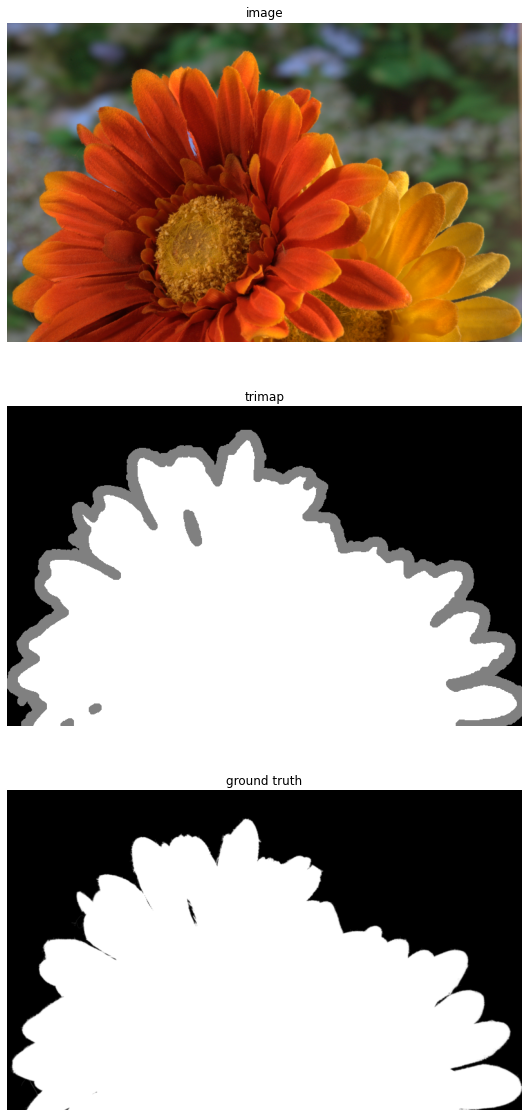

In [6]:
im,tr,gt = load_images("GT01.png")

In [7]:
''' helper function to divide the trimap into surely foreground and surely background and unknown region'''
def get_maps(trimap):
    bg = np.copy(trimap.astype(np.uint8))
    fg = np.copy(trimap.astype(np.uint8))
    un = np.copy(trimap.astype(np.uint8))
    bg[trimap != 0] = 0
    bg[trimap == 0] = 255
    fg[trimap != 255] = 0
    un[trimap == 128] = 255
    un[trimap != 128] = 0
    return bg,fg,un

    

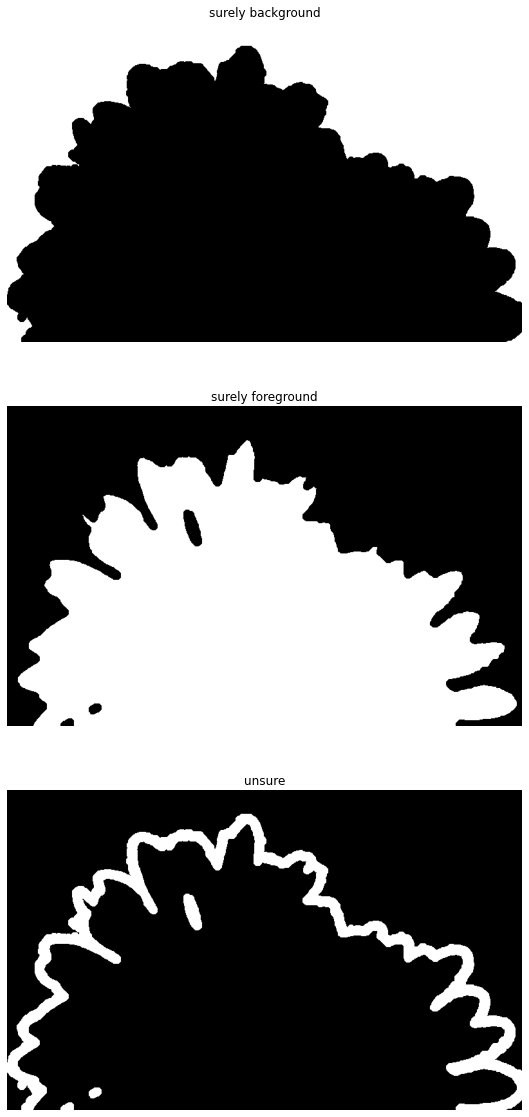

In [8]:
bg,fg,un = get_maps(tr)
display_images([bg,fg,un],["surely background","surely foreground","unsure"],3,1)

In [9]:
''' create a gaussian kernel of size k with sigma '''
def create_gaussian(k,sigma):
    return np.dot(cv2.getGaussianKernel(k,sigma),cv2.getGaussianKernel(k,sigma).T)


In [10]:
''' helper to zero pad the image '''
def pad_image(img,pad_x,pad_y):
    #grayscale
    if(np.ndim(img) == 2):
        (l,b) = img.shape
        new_image = np.zeros((l + 2 * pad_y, b + 2 * pad_x),dtype = np.uint8)
        new_image[pad_y : pad_y + l,pad_x : pad_x + b] = img
        return new_image
    #RGB
    else:
        (l,b,h) = img.shape
        new_image = np.zeros((l + 2 * pad_y, b + 2 * pad_x , h),dtype = np.uint8)
        new_image[pad_y : pad_y + l,pad_x : pad_x + b,:] = img
        return new_image
    
        
        

In [23]:
''' helper function to get neighbourhood '''
''' assuming the height and width to be odd for convenience'''
''' to do handle exceptions for now assuming its correct'''
def get_neighbourhood(img,centre_y,centre_x,height ,width ):
    new_centre_y = centre_y + height // 2
    new_centre_x = centre_x + width // 2
    ''' grayscale'''
    #print(np.ndim(img))
    if(np.ndim(img) == 2):
        pad_x = width // 2
        pad_y = height // 2
        padded_img = pad_image(img,pad_x,pad_y)
        (l,b) = img.shape
        left = new_centre_x - width // 2
        right = new_centre_x + width // 2
        up = new_centre_y - height // 2
        down = new_centre_y + height // 2
        if(left < 0 or up < 0 or right >= padded_img.shape[1] or down >= padded_img.shape[1] ):
            print("Neighbourhood error")
            print("Neighbourhood")
            print(left,right,up,down)
            print("Shapes")
            print(padded_img.shape,img.shape,height,width)
            print("Centre : {0},{1}".format(centre_y,centre_x))
            print("New Centre : {0},{1}".format(new_centre_y,new_centre_x))
            print("Done")

        return padded_img[up : down + 1,left : right + 1]
   
    elif np.ndim(img) == 3:
        
        (l,b,h) = img.shape
        pad_x = width // 2
        pad_y = height // 2
        padded_img = pad_image(img,pad_x,pad_y)
        left = new_centre_x - width // 2
        right = new_centre_x + width // 2
        up = new_centre_y - height // 2
        down = new_centre_y + height // 2
        if(left < 0 or up < 0 or right >= padded_img.shape[1] or down >= padded_img.shape[1] ):
            print("Neighbourhood error")
            print("Neighbourhood")
            print(left,right,up,down)
            print("Shapes")
            print(padded_img.shape,img.shape,height,width)
            print("Centre : {0},{1}".format(centre_y,centre_x))
            print("New Centre : {0},{1}".format(new_centre_y,new_centre_x))

            print("Done")
        return padded_img[up : down + 1,left : right + 1,:]
    
        
    
    

In [12]:

#clusters the neighbourhood around a location and tries to compute the mean and convariance for each

def getMeanandCovariance(pixels,kernel,num_cluster = 5):
    #print("MEAN ")
    #print(pixels.shape)
    #shape of the pixels is (N,3) where N is the valid foreground/background pixels
    means = []
    Covs = []
    clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
    labels = np.array(clusters.predict(pixels))
    for i in range(num_cluster):
        group = (labels == i) #truth array of the pixels withing the cluster
        this_pixels = np.asarray(pixels[group]) #pixel values of the cluster
        kernel_bin = np.reshape(kernel[group], (kernel[group].size,1)) #reshape the weights to the this_pixel
        kernel_sqrt = np.sqrt(kernel_bin) # useful for covariance computing

        #compute the weighted mean
        #compute the mean for each channel individually
        meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
                            np.dot(this_pixels[:,2], kernel_bin)])/np.sum(kernel_bin)
        #print("mean shape : {0} this_pixels shape : {1} kernel_bin.shape : {2}".format(meanbin.shape,this_pixels.shape,kernel_bin.shape))
        meanbin = np.reshape(meanbin, (3,))
        means.append(meanbin)

        diff = (this_pixels - meanbin)
        diff = np.multiply(kernel_sqrt, diff)
        covbin = np.eye(3)
        with np.errstate(divide='raise'): # raise errors, but dont stop execution when low number of clusters, and other cases
            try:
                covbin = np.dot(diff.T, diff)/(np.sum(kernel_bin) + 0.00001) + np.eye(3)*(10**(-5)) #adding small value to prevent singular matrices
            except Exception as e:
                print("Error")
                print(covbin.shape)
            #print("Maybe")
            #print(covbin)
        Covs.append(covbin)  
    means = np.array(means).T
    Covs = np.array(cv2.merge(Covs)) #merge 3 channels to 1
    #means have shape (3,K) K is the number of cluster
    #Covs have the shape (3,3,K) where K is the number of cluster
    #print(means.shape,Covs.shape,num_cluster)
    return means, Covs
        
        
    
    

In [13]:
'''
Solves the matting Equations Iteratively
Choose the best pair of (FG,BG) which maximizes the likelyhood of a given F,B,alpha
returns the value of F,B, alpha
'''
def Solver(fgmean, fgCov, bgmean, bgCov, Cmean, CCov, initial_Alpha,  minLikelihoodDelta = 10**(-3), maxIterations = 10):
    #means have shape (3,K) K is the number of cluster
    #Covs have the shape (3,3,K) where K is the number of cluster
    #CMean is a [a,b,c]
    #CCov is a scaler
    #initial_Alpha is a float
    #Some global required constants
    z,num_cluster = fgmean.shape
    solved_fg = np.zeros(3)
    solved_bg = np.zeros(3)
    solved_alpha = 0
    I = np.eye(3)
    nIterations = 0
    maxLikelihood = - np.inf
    
    for i in range(num_cluster):
        try:
            invCovF = np.linalg.inv(fgCov[:,:,i]) # compute inverse of the FG convariance matrix
        except Exception as e: # maynot be singular
            print("The Foreground matrix is not singular,Skipping for now")
            continue

        cur_fgmean = fgmean[:, i] #mean of ith FG Cluster 1*3

        for j in range(num_cluster):
            try:
                invCovB = np.linalg.inv(bgCov[:,:,j]) # compute inverse of the BG convariance matrix
            except Exception as e: # Sometimes its singular, so we dump the matrix and skip for now!
                print("The Background matrix is not singular,Skipping for now")
                continue
                

            cur_bgmean = bgmean[:, j] #mean of ith BG Cluster

            #Initialization for the iterative solver
            alpha = initial_Alpha
            nIterations = 0
            prevLikelihood = -np.inf
            while True:
                nIterations += 1

                #SOLVE THE EQUATION DESCRIBED IN THE PAPER

                #define A
                a11 = invCovF + I*(alpha/CCov)**2  #3X3
                a12 = I*(alpha*(1-alpha)/(CCov)**2) # 3X3
                a22 = invCovB + I*((1 - alpha)/CCov)**2 #3X3
                r1 = np.hstack((a11, a12)) #create the top row 3*6
                r2 = np.hstack((a12, a22)) # create the bottom row 3*6
                A = np.vstack((r1, r2)) #create the final matrix 6*6

                #define b
                b11 = np.dot(invCovF, cur_fgmean) + Cmean*(alpha/CCov**2)  # 3*1
                b12 = np.dot(invCovB, cur_bgmean) + Cmean*(1-alpha)/(CCov**2) # 3*1
                b = np.concatenate((b11, b12)).T #(6,)

                #solve Ax = b
                try:
                    x = np.linalg.solve(A, b)
                except Exception as e: # Sometimes there is an issue with solving if A is non invertible. This did not occur after singular matrices were skipped, but is still there for safety.
                    print("ERROR SOLVING")
                    break


                #assign fg and bg that are solved
                fgCol = x[0:3]
                bgCol = x[3:6]

                # SOLVE FOR ALPHA using estimated F, B, C        
                alpha = np.dot((Cmean.T - bgCol).T, (fgCol - bgCol))/(np.sum(np.square(fgCol - bgCol))) #float

                #clip Alpha
                if alpha < 0:
                      alpha = 0
                if alpha > 1:
                      alpha = 1


                # Compute Likelyhood
                
                #L[0] = -np.sum((Cmean.T - alpha*fgCol - (1-alpha)*bgCol)**2)/(colCov**2) # L(C|F,B, alpha)
                L1 = -(np.linalg.norm((Cmean.T - alpha*fgCol - (1-alpha)*bgCol),2)**2)/(CCov**2) # L(C|F,B, alpha)
                LF = -(np.dot(np.dot((fgCol - cur_fgmean.T).T, invCovF), (fgCol - cur_fgmean.T).T)/2) #L(F)
                LB = -(np.dot(np.dot((bgCol - cur_bgmean.T).T, invCovB), (bgCol - cur_bgmean.T).T)/2) #L(B)
                L = np.array([L1,LF,LB])

                likelihood = np.sum(L)

                if likelihood > maxLikelihood: # If best likelihood so far, use that
                    solved_alpha = alpha
                    maxLikelihood = likelihood
                    solved_fg = fgCol
                    solved_bg = bgCol

                # Stop solving if the solver saturates or if it exceeds the maximum number of iterations per cluster pair
                if abs(prevLikelihood - likelihood) < minLikelihoodDelta or nIterations > maxIterations: # Stop solving
                    break

                prevLikelihood = likelihood

        return solved_fg,solved_bg, solved_alpha

In [29]:
def solve(im,trimap,gt,thresh = 10):
    # get the regions for each type
    bg,fg,unk = get_maps(trimap)
    y,x = np.where(unk != 0) # locations where classification is unknown
    unsolved_loc = list(set(zip(y,x)))
    unsolved_loc = sorted(unsolved_loc,key = lambda x : x[0]) #top to bottom
    # this is essentially the alpha matrix
    # 1 for foreground pixels
    # 0 for background pixels
    # nan for unknowns.
    mask = np.copy(unk).astype(np.float64)
    
   
    
    mask[unk != 0] = np.nan #replace unknown regions with nan
    mask[fg != 0] = 1 #replace foreground region with 1
    
    #print("mask")
    #print("mask unique")
    #print(np.unique(mask))
    #print(mask)
    #print(mask.shape)
    #print("")
    
    #convert fg to RGB

    fg1 = np.zeros((im.shape))
    fg1[:,:,0] = fg
    fg1[:,:,1] = fg
    fg1[:,:,2] = fg
    #convert bg to RGB for bitwise operations
    bg1 = np.zeros((im.shape))
    bg1[:,:,0] = bg
    bg1[:,:,1] = bg
    bg1[:,:,2] = bg

    #generate surely background and surely foreground images
    f = cv2.bitwise_and(fg1.astype(np.uint8),im.astype(np.uint8))
    b = cv2.bitwise_and(bg1.astype(np.uint8),im.astype(np.uint8))
    #display_images([f,b,im],["foreground","background","original"],3,1)
    
    iteration = 0
    solved = []
    tosolve = np.copy(unsolved_loc)
    sad_score = 0
    pass_num = 0
    pass_thresh = 5
    window_size = 13
    sigma = 10
    while(len(tosolve) > 0):
        pass_num += 1
        tosolve = []
        #create a list of locations to be solved
        for loc in unsolved_loc :
            #check it is not already solved
            if loc not in solved:
                tosolve.append(loc)
        if pass_num > pass_thresh and pass_num % 3:
            window_size += 2 #initally odd,remains odd.Window size increases when too many unknowns
        print("PASS NUMBER : {0} , WINDOW SIZE : {1}".format(pass_num,window_size))
        for loc in tosolve:
            gaussian_kernel = create_gaussian(window_size,sigma) #create kernel
            alpha = get_neighbourhood(mask,loc[0],loc[1],window_size,window_size)
            #print("alpha")
            #print(alpha)
            #print(alpha.shape)
            
            #find fg  pixels for clustering
            kernel_f = np.multiply(np.square(alpha),gaussian_kernel)
            fg_window = get_neighbourhood(f,loc[0],loc[1],window_size,window_size)
            #print("window size")
            #print(fg_window)
            #print(fg_window.shape)
            
            known = np.nan_to_num(kernel_f) > 0 #return a boolean array with true values for non-zero and non-nan values
            fg_pixel = fg_window[known] #extract the selected pixel location
            #print("fg_pixel")
            #print(fg_pixel)
            #print(fg_pixel.shape)
            #print("fg_pixel.shape")
            kernel_f = kernel_f[known] # extract the selected pixel location
            
            #find  bg pixels for clustering
            kernel_b = np.multiply(np.square(1- alpha),gaussian_kernel)
            bg_window = get_neighbourhood(b,loc[0],loc[1],window_size,window_size)
            known = np.nan_to_num(kernel_b) > 0 #return a boolean array with true values for non-zero and non-nan values
            bg_pixel = bg_window[known] #extract the selected pixel location
            kernel_b = kernel_b[known] # extract the selected pixel location
            
            '''
            print("Check")
            print(fg_pixel)
            print(fg_pixel.shape)
            #print
            print(bg_pixel)
            print(bg_pixel.shape)
            print("")
            '''
            
            #check sufficient data to solve the proble
            if(len(fg_pixel) >= thresh and len(bg_pixel) >= thresh):
                    
                #print("Check")
                #print(fg_pixel)
                #print(fg_pixel.shape)
                #print
                #print(bg_pixel)
                #print(bg_pixel.shape)
                #print("")
                
                fgmean,fgCov = getMeanandCovariance(fg_pixel,kernel_f,num_cluster = 5)
                bgmean,bgCov = getMeanandCovariance(bg_pixel,kernel_b,num_cluster = 5)
                
                #observed_c
                Cmean = im[loc[0],loc[1],:]
                CCov = 3 #tunable parameter
                #print(Cmean,CCov)
                
                #take intial guess as mean
                initial_alpha = np.nanmean(alpha)
                
                #print(initial_alpha)
                
                
                #iteratively solve!
                final_fg, final_bg, final_alpha = Solver(fgmean, fgCov, bgmean, bgCov, Cmean, CCov, initial_alpha, maxIterations = 50)


                #update the estimated values
                
                #print(final_fg,final_bg,final_alpha)
                mask[loc[0],loc[1]] = final_alpha
                f[loc[0],loc[1],:] = np.array(final_fg)
                b[loc[0],loc[1],:] = np.array(final_bg)
                solved.append(loc)


                #print occasional status updates
                if iteration % 300 == 0:
                    print("PASS : ", pass_num)
                    print("WINDOW SIZE = ", window_size)
                    print('SOLVED LOCATIONS = ', len(solved))
                    print('REMAINING LOCATIONS = ', len(tosolve) - len(solved))
                    #sad = np.sum(np.absolute((cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)/255).astype(np.float) - np.nan_to_num(mask)))
                    #print('SAD = ', sad)
                    print('---------------------------------------------')
                    final_alpha = cv2.cvtColor((mask*255).astype(np.uint8), cv2.COLOR_GRAY2BGR) #3 c
                    #showMultiImages((fg, bg, gt, alpha3channel), 'CURRENT')


                iteration += 1
    #sad = np.sum(np.absolute((cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY )/255).astype(np.float) - np.nan_to_num(mask)))
    print('SOLVER COMPLETED IN ', iteration, 'ITERATIONS')
    print('---------------------------------------------')
    print('---------------------------------------------')
    print('---------------------------------------------')


    return f, b, mask
                
                
            
            
            
        
    
    

In [32]:
import time
def run(index):
    t1 = time.time()
    scale = 0.2
    print("Reducing the size for faster running of sample code")
    small_im = cv2.resize(np.copy(im), (0,0), fx = scale, fy = scale)
    small_tr = cv2.resize(np.copy(tr), (0,0), fx = scale, fy = scale)
    small_gt = cv2.resize(np.copy(gt), (0,0), fx = scale, fy = scale)
    print("Sizes")
    print(small_im.shape)
    print(small_tr.shape)
    print(small_gt.shape)
    display_images([small_im,small_tr,small_gt],["small input","small trimap","small ground truth"],3,1)
    f,b, mask = solve(small_im,small_tr,small_gt,thresh = 10)
    #display_images([f,b,small_gt],["small input","small trimap","small ground truth"],3,1)

    t2 = time.time()
    print("Time taken : {0}".format(t2 - t1))
    return f,b,mask

Reducing the size for faster running of sample code
Sizes
(99, 160, 3)
(99, 160)
(99, 160)
PASS NUMBER : 1 , WINDOW SIZE : 13
PASS :  1
WINDOW SIZE =  13
SOLVED LOCATIONS =  1
REMAINING LOCATIONS =  1534
---------------------------------------------
PASS :  1
WINDOW SIZE =  13
SOLVED LOCATIONS =  301
REMAINING LOCATIONS =  1234
---------------------------------------------


<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  13
SOLVED LOCATIONS =  601
REMAINING LOCATIONS =  934
---------------------------------------------


<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  13
SOLVED LOCATIONS =  901
REMAINING LOCATIONS =  634
---------------------------------------------
PASS :  1
WINDOW SIZE =  13
SOLVED LOCATIONS =  1201
REMAINING LOCATIONS =  334
---------------------------------------------


<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  13
SOLVED LOCATIONS =  1501
REMAINING LOCATIONS =  34
---------------------------------------------


<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS NUMBER : 2 , WINDOW SIZE : 13
PASS NUMBER : 3 , WINDOW SIZE : 13
PASS NUMBER : 4 , WINDOW SIZE : 13
PASS NUMBER : 5 , WINDOW SIZE : 13
PASS NUMBER : 6 , WINDOW SIZE : 13
PASS NUMBER : 7 , WINDOW SIZE : 15


<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS NUMBER : 8 , WINDOW SIZE : 17
PASS NUMBER : 9 , WINDOW SIZE : 17
PASS NUMBER : 10 , WINDOW SIZE : 19


<ipython-input-12-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-12-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS NUMBER : 11 , WINDOW SIZE : 21
SOLVER COMPLETED IN  1535 ITERATIONS
---------------------------------------------
---------------------------------------------
---------------------------------------------
Time taken : 58.613579511642456


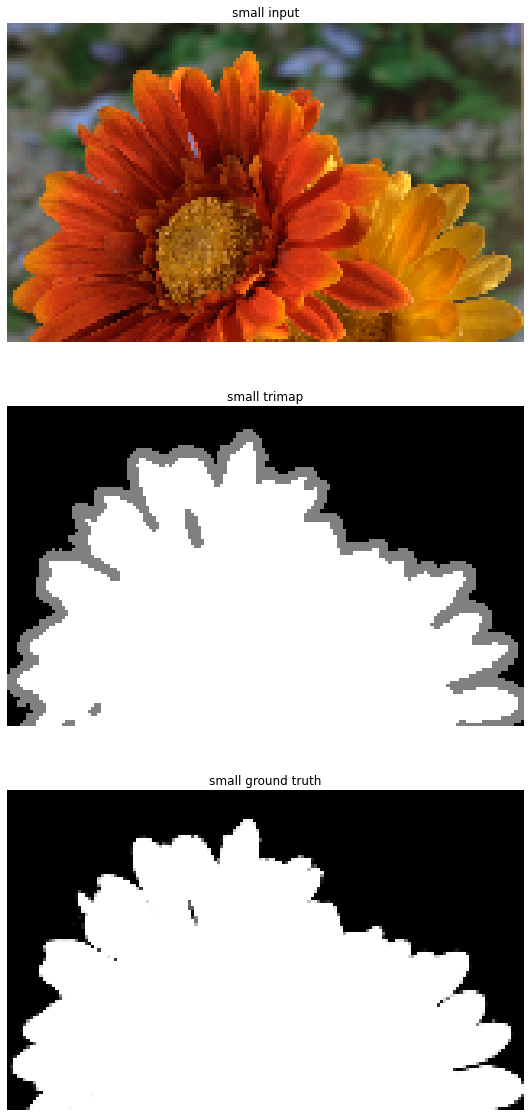

In [33]:
f,b,mask = run(1)

In [ ]:
''' add multiprocessing because this is slow as hell
from multiprocessing import Pool
import os
pool = Pool(processes=os.cpu_count() - 2)
print(os.cpu_count())
print(pool)
'''


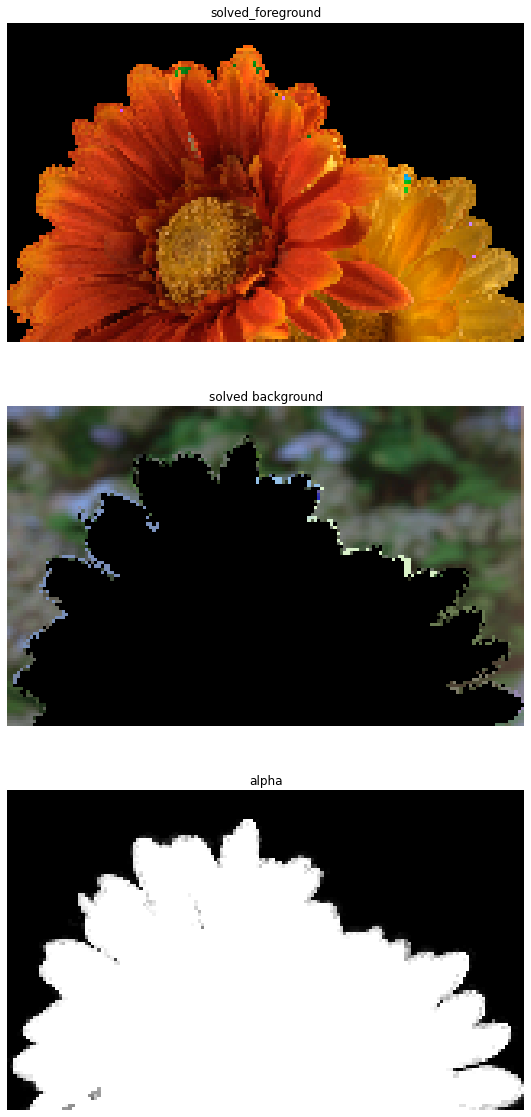

In [34]:
display_images([f,b,mask],["solved_foreground","solved background","alpha"],3,1)

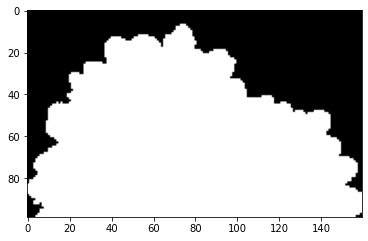

In [36]:
matte = np.zeros((f.shape[0],f.shape[1]))
for i in range(matte.shape[0]):
    for j in range(matte.shape[1]):
        if(f[i,j,0] == 0 and f[i,j,1] == 0 and f[i,j,2] == 0):
            matte[i,j] = 0
        else:
            matte[i,j] = 255
plt.imshow(matte,cmap = 'gray')

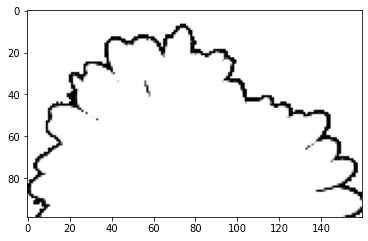

In [38]:
small_gt = cv2.resize(gt,(0,0),fx = 0.2,fy = 0.2)
small_tr = cv2.resize(tr,(0,0),fx = 0.2,fy = 0.2)
plt.imshow((small_gt - matte),cmap = 'gray')



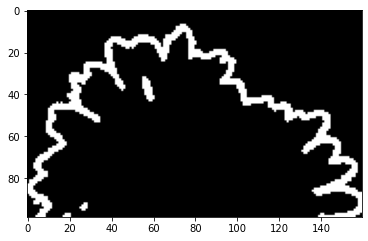

In [39]:
plt.imshow((matte - small_tr),cmap = 'gray')